# VAD(Voice Activity Detection)

## 1. 데이터 로드

In [5]:
import torch
import torchaudio
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import wiener
from skimage.metrics import structural_similarity as ssim
from torchaudio.transforms import Spectrogram
from pystoi.stoi import stoi
from torchaudio.transforms import Vad
from scipy.signal import wiener
from scipy.io.wavfile import write
import IPython.display as ipd



In [27]:
import os
import librosa

# 파일이 있는 폴더 경로
folder_path = r"C:\Users\chosun\Desktop\연구실\데이터셋\mix"

# 모든 .wav 파일 경로 가져오기
wav_files = [f for f in os.listdir(folder_path) if f.endswith('.wav')]

# 모든 WAV 파일 로드하기
waveforms = []
sample_rates = []

for wav_file in wav_files:
    file_path = os.path.join(folder_path, wav_file)
    try:
        # librosa로 오디오 파일 로드
        waveform, sample_rate = librosa.load(file_path, sr=None)
        waveforms.append(waveform)
        sample_rates.append(sample_rate)
    except Exception as e:

# 확인
print(f"전체 로드된 파일 수: {len(waveforms)}")


파일 1.wav 로드 성공! Sample rate: 48000, Waveform shape: (872956,)
파일 10.wav 로드 성공! Sample rate: 48000, Waveform shape: (895538,)
파일 100.wav 로드 성공! Sample rate: 48000, Waveform shape: (502861,)
파일 1000.wav 로드 성공! Sample rate: 48000, Waveform shape: (1169655,)
파일 10000.wav 로드 성공! Sample rate: 48000, Waveform shape: (1275264,)
파일 1001.wav 로드 성공! Sample rate: 48000, Waveform shape: (1226524,)
파일 1002.wav 로드 성공! Sample rate: 48000, Waveform shape: (701424,)
파일 1003.wav 로드 성공! Sample rate: 48000, Waveform shape: (232313,)
파일 1004.wav 로드 성공! Sample rate: 48000, Waveform shape: (1203686,)
파일 1005.wav 로드 성공! Sample rate: 48000, Waveform shape: (191562,)
파일 1006.wav 로드 성공! Sample rate: 48000, Waveform shape: (703080,)
파일 1007.wav 로드 성공! Sample rate: 48000, Waveform shape: (237109,)
파일 1008.wav 로드 성공! Sample rate: 48000, Waveform shape: (482316,)
파일 1009.wav 로드 성공! Sample rate: 48000, Waveform shape: (1333819,)
파일 101.wav 로드 성공! Sample rate: 48000, Waveform shape: (976714,)
파일 1010.wav 로드 성공! Sample 

## 2. 데이터 확인

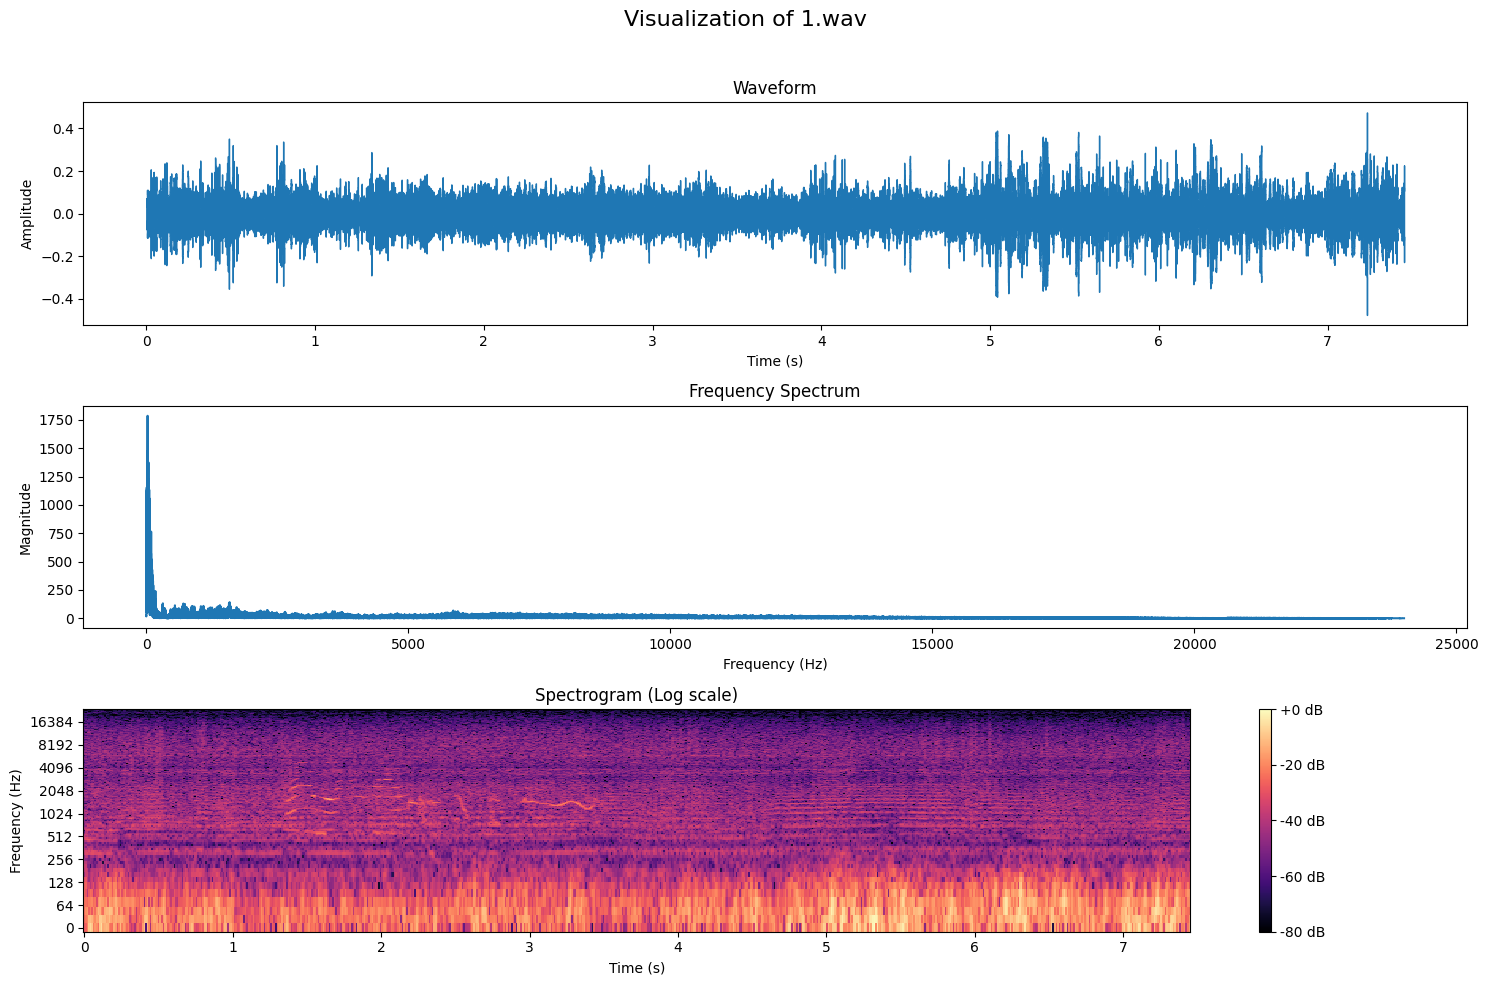

Playing audio:


In [47]:
def visualize_audio_and_play(waveform, sample_rate, title="Audio Visualization"):
    # 시각화 크기 설정
    plt.figure(figsize=(15, 10))

    # 1. Waveform
    plt.subplot(3, 1, 1)
    librosa.display.waveshow(waveform, sr=sample_rate)
    plt.title("Waveform")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")

    # 2. Frequency Spectrum
    plt.subplot(3, 1, 2)
    fft = np.fft.fft(waveform)  # Fast Fourier Transform
    magnitude = np.abs(fft)     # Magnitude
    frequency = np.linspace(0, sample_rate, len(magnitude))
    plt.plot(frequency[:len(magnitude)//2], magnitude[:len(magnitude)//2])
    plt.title("Frequency Spectrum")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")

    # 3. Spectrogram
    plt.subplot(3, 1, 3)
    S = librosa.stft(waveform)  # Short-time Fourier Transform
    S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)  # Convert to decibel
    librosa.display.specshow(S_db, sr=sample_rate, x_axis="time", y_axis="log")
    plt.colorbar(format="%+2.0f dB")
    plt.title("Spectrogram (Log scale)")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")

    # 전체 제목 및 시각화
    plt.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    # 오디오 출력
    print("Playing audio:")
    display(Audio(waveform, rate=sample_rate))

# 예제 파일 로드 및 시각화
file_path = r"C:\Users\chosun\Desktop\연구실\데이터셋\mix\13.wav"
waveform, sample_rate = librosa.load(file_path, sr=None)

visualize_audio_and_play(waveform, sample_rate, title="Visualization of 1.wav")


## 데이터 전처리

Audio loaded. Sample rate: 16000, Waveform shape: (119258,)
Applied Winner filter for noise reduction.
Removed NaN or infinite values from the filtered waveform.
Computed STFT. Shape: (513, 466)
Applied IDR mask to the spectrogram.
Reconstructed waveform from masked STFT.


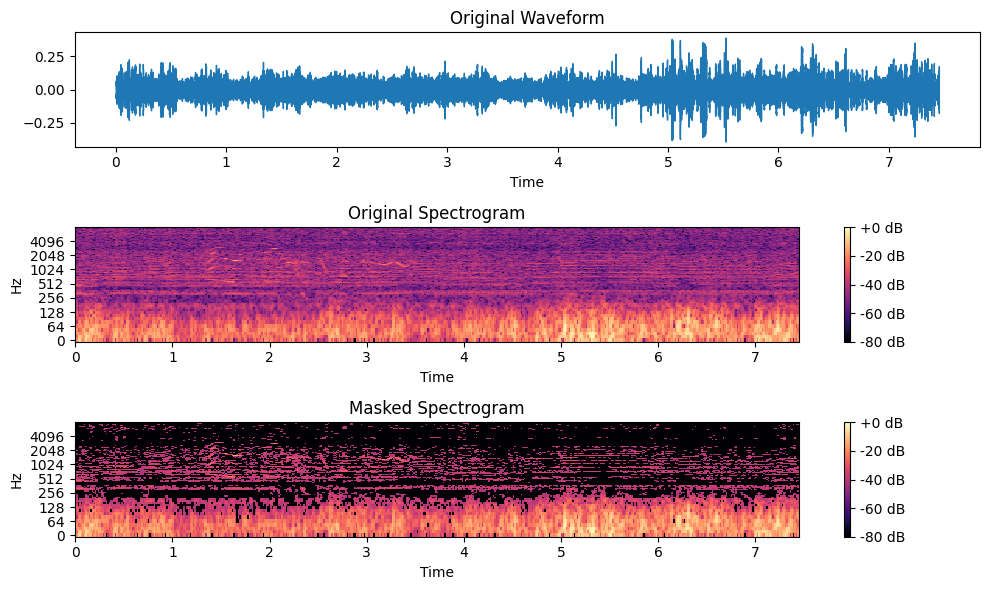

In [48]:
# Winner 필터 함수
def winner_filter(signal, noise_estimate, beta=1):
    noisy_signal_power = np.abs(noise_estimate) ** 2
    estimate_power = np.abs(signal) ** 2
    ratio = estimate_power / (estimate_power + beta * noisy_signal_power)
    filtered_signal = signal * ratio
    filtered_signal = np.nan_to_num(filtered_signal)  # NaN/Inf 제거
    return filtered_signal

# IDR 마스크 함수
def apply_idr_mask(stft_result, threshold=0.5):
    magnitude, phase = np.abs(stft_result), np.angle(stft_result)
    mask = magnitude > threshold
    masked_magnitude = magnitude * mask
    return masked_magnitude * np.exp(1j * phase)

# 전처리 함수
def preprocess_audio_for_vad(file_path, sr=16000, beta=1, threshold=0.5, plot=False):
    # Step 1: 파일 로드
    waveform, _ = librosa.load(file_path, sr=sr)
    print(f"Audio loaded. Sample rate: {sr}, Waveform shape: {waveform.shape}")

    # Step 2: Winner 필터 적용
    noise_estimate = np.random.normal(0, 0.01, len(waveform))  # 노이즈 추정치 (임의 설정)
    filtered_waveform = winner_filter(waveform, noise_estimate, beta=beta)
    print("Applied Winner filter for noise reduction.")

    # Step 3: NaN/Inf 값 제거
    filtered_waveform = np.nan_to_num(filtered_waveform)
    print("Removed NaN or infinite values from the filtered waveform.")

    # Step 4: STFT 변환
    stft_result = librosa.stft(filtered_waveform, n_fft=1024, hop_length=256, win_length=1024)
    print(f"Computed STFT. Shape: {stft_result.shape}")

    # Step 5: IDR 마스크 적용
    masked_stft = apply_idr_mask(stft_result, threshold=threshold)
    print("Applied IDR mask to the spectrogram.")

    # Step 6: 복원
    reconstructed_waveform = librosa.istft(masked_stft, hop_length=256, win_length=1024)
    print("Reconstructed waveform from masked STFT.")

    # 시각화 (옵션)
    if plot:
        plt.figure(figsize=(10, 6))

        plt.subplot(3, 1, 1)
        librosa.display.waveshow(waveform, sr=sr)
        plt.title("Original Waveform")

        plt.subplot(3, 1, 2)
        librosa.display.specshow(librosa.amplitude_to_db(np.abs(stft_result), ref=np.max), 
                                 sr=sr, hop_length=256, y_axis='log', x_axis='time')
        plt.title("Original Spectrogram")
        plt.colorbar(format="%+2.0f dB")

        plt.subplot(3, 1, 3)
        librosa.display.specshow(librosa.amplitude_to_db(np.abs(masked_stft), ref=np.max), 
                                 sr=sr, hop_length=256, y_axis='log', x_axis='time')
        plt.title("Masked Spectrogram")
        plt.colorbar(format="%+2.0f dB")

        plt.tight_layout()
        plt.show()

    # 오디오 재생
    return reconstructed_waveform, ipd.Audio(reconstructed_waveform, rate=sr)

# 사용 예제
file_path = r"C:\Users\chosun\Desktop\연구실\데이터셋\mix\13.wav"
preprocessed_waveform, audio_player = preprocess_audio_for_vad(file_path, sr=16000, beta=1, threshold=0.5, plot=True)

# 결과 재생
audio_player


## VAD(Voice Activity Detection) 모델

Audio loaded. Sample rate: 16000, Waveform shape: (119258,)
Applied Winner filter for noise reduction.
Removed NaN or infinite values from the filtered waveform.
VAD applied. Detected 223 frames of speech.
Extracted speech waveform. Shape: (227764,)


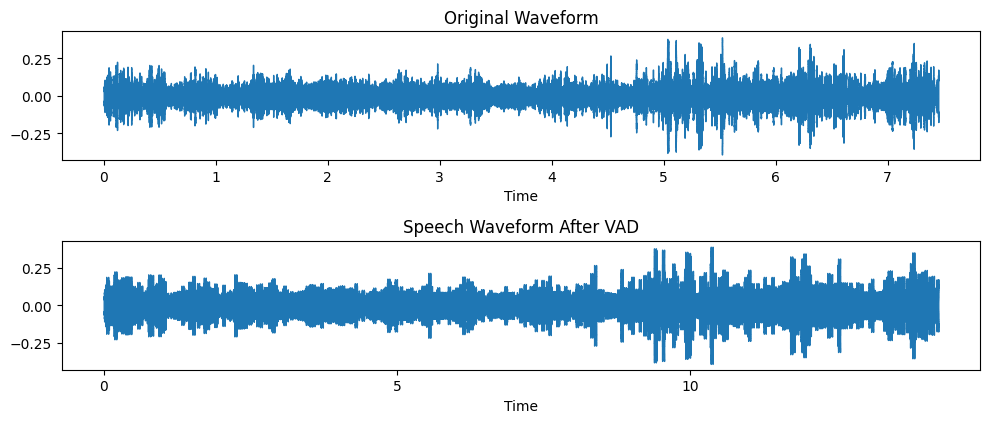

In [57]:
import librosa
import numpy as np
import librosa.display
import matplotlib.pyplot as plt

# VAD 알고리즘 (단순 에너지 기반)
def energy_vad(waveform, sr=16000, frame_size=1024, hop_size=512, threshold=0.6):
    # 에너지 계산
    energy = np.square(waveform)
    
    # 프레임별 에너지 계산
    frame_energy = [np.sum(energy[i:i+frame_size]) for i in range(0, len(waveform), hop_size)]
    
    # 에너지가 임계값을 초과하면 음성, 그렇지 않으면 비음성
    vad_result = np.array([1 if energy > threshold else 0 for energy in frame_energy])
    
    return vad_result

# 음성 구간 추출 함수
def extract_speech_from_vad(waveform, vad_result, frame_size=1024, hop_size=512):
    speech_segments = []
    for idx, vad in enumerate(vad_result):
        if vad == 1:
            start_idx = idx * hop_size
            end_idx = start_idx + frame_size
            speech_segments.append(waveform[start_idx:end_idx])
    
    # 음성 구간 이어붙이기
    speech_waveform = np.concatenate(speech_segments)
    return speech_waveform

# VAD 적용 후 음성 추출
def preprocess_and_apply_vad(file_path, sr=16000, beta=1, threshold=0.5, vad_threshold=0.6, plot=False):
    # Step 1: 파일 로드
    waveform, _ = librosa.load(file_path, sr=sr)
    print(f"Audio loaded. Sample rate: {sr}, Waveform shape: {waveform.shape}")

    # Step 2: Winner 필터 적용
    noise_estimate = np.random.normal(0, 0.01, len(waveform))  # 노이즈 추정치 (임의 설정)
    filtered_waveform = winner_filter(waveform, noise_estimate, beta=beta)
    print("Applied Winner filter for noise reduction.")

    # Step 3: NaN/Inf 값 제거
    filtered_waveform = np.nan_to_num(filtered_waveform)
    print("Removed NaN or infinite values from the filtered waveform.")

    # Step 4: VAD 적용
    vad_result = energy_vad(filtered_waveform, sr=sr, threshold=vad_threshold)
    print(f"VAD applied. Detected {np.sum(vad_result)} frames of speech.")

    # Step 5: 음성 구간 추출
    speech_waveform = extract_speech_from_vad(filtered_waveform, vad_result)
    print(f"Extracted speech waveform. Shape: {speech_waveform.shape}")

    # 시각화 (옵션)
    if plot:
        plt.figure(figsize=(10, 6))

        # 원본 음성 파형
        plt.subplot(3, 1, 1)
        librosa.display.waveshow(waveform, sr=sr)
        plt.title("Original Waveform")

        # VAD 적용 후 음성 파형
        plt.subplot(3, 1, 2)
        librosa.display.waveshow(speech_waveform, sr=sr)
        plt.title("Speech Waveform After VAD")

        plt.tight_layout()
        plt.show()

    # 결과 반환 (음성 신호 및 재생)
    return speech_waveform, ipd.Audio(speech_waveform, rate=sr)

# 사용 예제
file_path = r"C:\Users\chosun\Desktop\연구실\데이터셋\mix\13.wav"
speech_waveform, audio_player = preprocess_and_apply_vad(file_path, sr=16000, beta=1, threshold=0.5, vad_threshold=0.6, plot=True)

# 결과 재생
audio_player


## 4. Transformer 모델

In [64]:
import torch
import torch.nn as nn
import torch.optim as optim
import librosa
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score

# Transformer 모델 구현
class TransformerVAD(nn.Module):
    def __init__(self, input_dim=1, num_heads=8, num_layers=6, d_model=512, dropout=0.1, num_classes=2):
        super(TransformerVAD, self).__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        self.transformer = nn.Transformer(d_model=d_model, nhead=num_heads, num_encoder_layers=num_layers, dropout=dropout)
        self.fc_out = nn.Linear(d_model, num_classes)
    
    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(1, 0, 2)  # Transformer expects (seq_len, batch_size, features)
        x = self.transformer(x)
        x = x.mean(dim=0)  # Average over sequence length
        x = self.fc_out(x)
        return x


In [65]:
# 데이터셋 클래스
class AudioDataset(Dataset):
    def __init__(self, file_paths, labels, sr=16000, window_size=1024, hop_size=512):
        self.file_paths = file_paths
        self.labels = labels
        self.sr = sr
        self.window_size = window_size
        self.hop_size = hop_size
    
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        label = self.labels[idx]
        
        # 파일 로드
        waveform, _ = librosa.load(file_path, sr=self.sr)
        
        # Short-Time Fourier Transform (STFT)
        stft_result = librosa.stft(waveform, n_fft=self.window_size, hop_length=self.hop_size)
        magnitude, phase = np.abs(stft_result), np.angle(stft_result)
        magnitude = torch.tensor(magnitude, dtype=torch.float32).unsqueeze(0)  # Add channel dimension

        return magnitude, torch.tensor(label, dtype=torch.long)

In [66]:
# VAD 기준 에너지 계산
def energy_vad(waveform, sr=16000, threshold=0.6, frame_size=1024, hop_size=512):
    frames = len(waveform) // hop_size
    vad_result = []
    
    for i in range(frames):
        start_idx = i * hop_size
        end_idx = start_idx + frame_size
        frame = waveform[start_idx:end_idx]
        
        # 에너지 계산
        energy = np.sum(np.abs(frame)**2)
        vad_result.append(1 if energy > threshold else 0)
    
    return np.array(vad_result)

In [71]:
# 모델 학습 및 평가
def train_and_evaluate(model, train_loader, val_loader, epochs=50, device='cpu'):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        train_loss, correct_train, total_train = 0, 0, 0
        
        # 학습 단계
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(output, 1)
            correct_train += (predicted == target).sum().item()
            total_train += target.size(0)
        
        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(correct_train / total_train)

        # 검증 단계
        model.eval()
        val_loss, correct_val, total_val = 0, 0, 0
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                
                output = model(data)
                loss = criterion(output, target)
                val_loss += loss.item()
                _, predicted = torch.max(output, 1)
                correct_val += (predicted == target).sum().item()
                total_val += target.size(0)

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(correct_val / total_val)

        # 10 에폭마다 출력
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs} - Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {correct_train/total_train:.4f}, Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {correct_val/total_val:.4f}")


In [ ]:
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    # 손실 그래프
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss vs Epochs')

    # 정확도 그래프
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy vs Epochs')
    plt.tight_layout()
    plt.show()

# 사용 예시
file_paths = ['path_to_file1.wav', 'path_to_file2.wav', 'path_to_file3.wav']  # 파일 경로
labels = [1, 0, 1]  # 1: 음성, 0: 노이즈
train_dataset = AudioDataset(file_paths, labels)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

val_dataset = AudioDataset(file_paths, labels)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TransformerVAD().to(device)
train_and_evaluate(model, train_loader, val_loader, epochs=50, device=device)